# Data wrangling

## Lecture objectives

1. Gain more experience with parsing different datasets
2. Understand the different types of joins: left, right, inner, outer, 1:1, 1:many, etc.
3. Learn how to join different datasets in `pandas` using indices
4. Learn how to aggregate in `pandas` using `groupby`

Data wrangling, or data munging, is the process of cleaning, transforming, and aggregating data to make it usable for analysis. We've already done some of this implicitly, for example through dealing with missing data in Craigslist posts, or converting from strings to numeric formats.

Data wrangling is perhaps the least glamorous part of data science, but the most time consuming. Don't be surprised if this takes up 80% of your time. 

## Joins

Before you start to join two (or more) datasets together, think about what end result you want. For example:
* Do you want to keep all the observations from dataset *A*, even if they don't match to anything in dataset *B*? This is a "left join."
* Do you want to keep all the observations, even if they are only in one dataset? This is an "outer join."
* Do you only want to keep the observations that are in both datasets? This is an "inner join."
* Do you want to allow more than one match? This is a "many-to-one," "one-to-many," or "many-to-many" join (not pictured.)

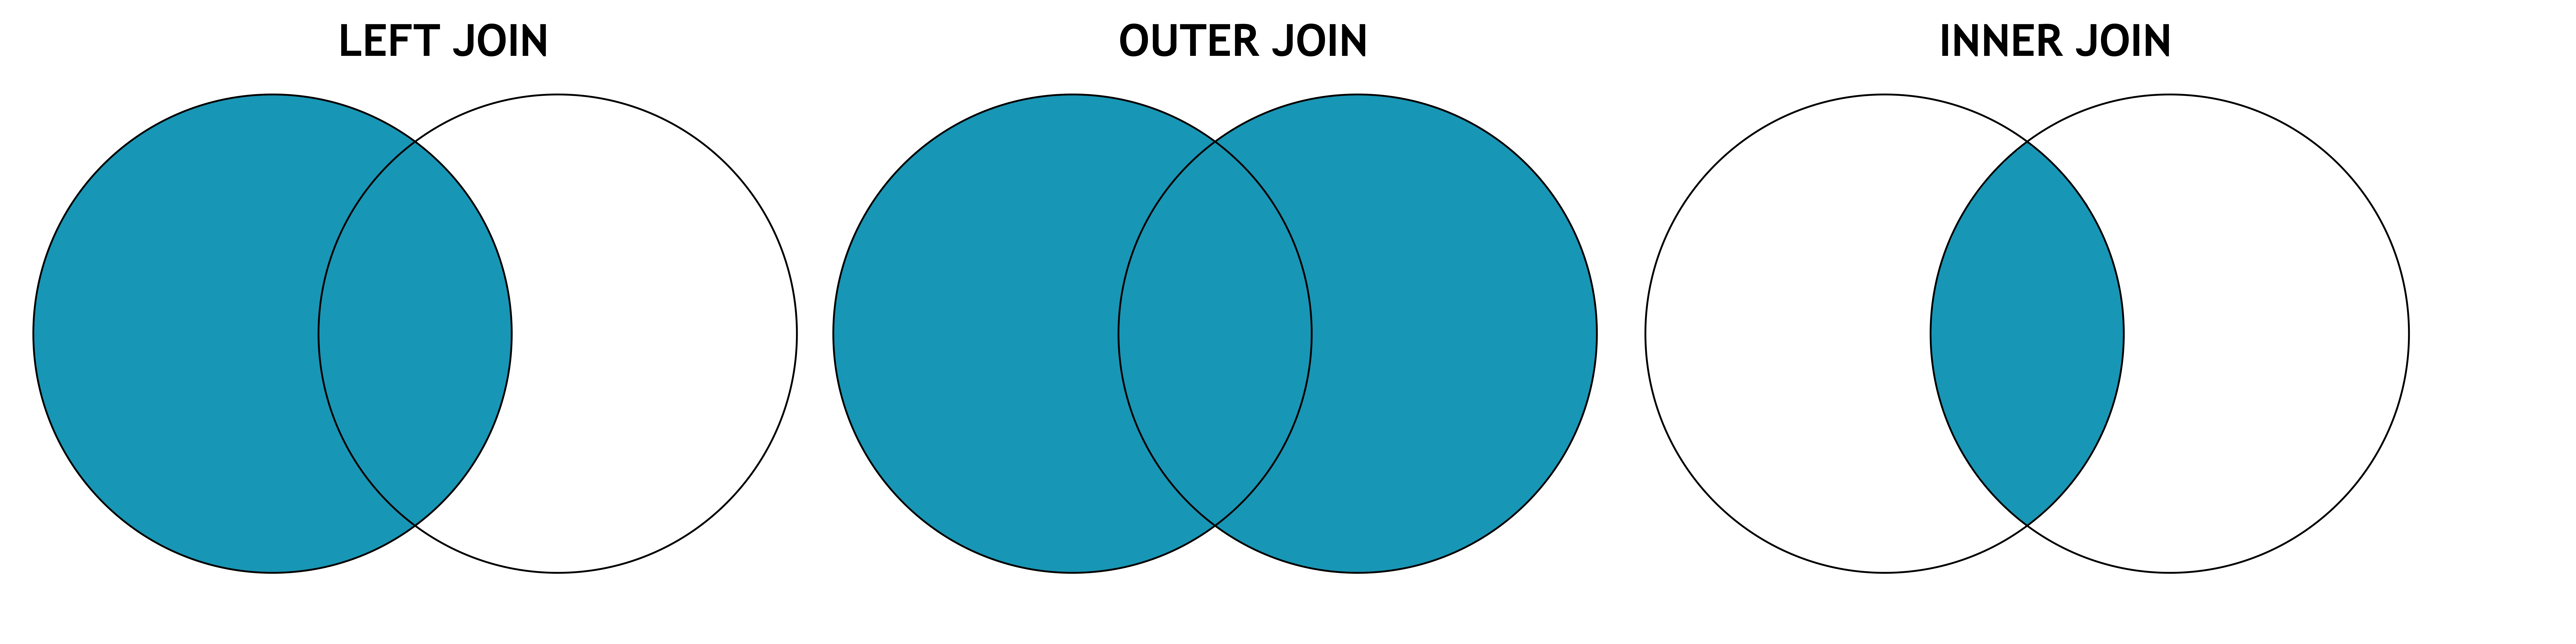

Sometimes, a data provider provides multiple tables, but is explicit about how they are joined to each other. A good example is the [California traffic collision dataset, SWITRS](https://tims.berkeley.edu/help/SWITRS.php). Here, you can see that the `COLLISION` dataset joins to the `PARTY` dataset using the `CASE ID` column. Also note that there is a `1:N` match, meaning that each collision may have more than one party.

I downloaded one month of data (to save you from registering) from Ventura County.

In [ ]:
import pandas as pd
collisionDf = pd.read_csv('data/Collisions.csv')
partyDf = pd.read_csv('data/Parties.csv')
victimDf = pd.read_csv('data/Victims.csv')

The easiest way to join two data frames in `pandas` is through setting the index. We've used indexes implicitly so far, but now let's look at them in more detail.

All these dataframes have an integer index (`pandas` creates this when we load in the .csv file). That means that `.iloc`, which returns based on row number, and `.loc`, which returns based on the index, produce identical results.

In [ ]:
print (collisionDf.index)
print (collisionDf.index.values)

In [ ]:
print (collisionDf.loc[0])

In [ ]:
print (collisionDf.iloc[0])

We can set the index to any column we want in the dataframe, or even multiple columns. For example, let's set the index to `CASE_ID`. The `inplace` keyword argument means that we modify the existing dataframe rather than returning a copy of it.

In [ ]:
collisionDf.set_index('CASE_ID', inplace=True)
partyDf.set_index('CASE_ID', inplace=True)
print(collisionDf.head())

In [ ]:
# if we want to check what the index is, you can try
print(collisionDf.index)

Since we've changed the index, `.loc` and `.iloc` no longer return the same thing. Indeed, this doesn't work because index `0` no longer exists. Notice we get a `KeyError`, meaning that the index key is not found.

In [ ]:
print (collisionDf.loc[0])

But `.iloc` still works. And we can use `.loc` with the CASENO.

In [ ]:
print (collisionDf.iloc[0])

In [ ]:
print (collisionDf.loc[8167180])

Now let's do the join. There are several functions that do this in `pandas`. I find `.join()` the easiest in most situations.

Remember that the dataset documentation told us that we should join on `CASENO`, which is now our index. You can join on any column (not just the index), but using the index is usually easier and faster.

In [ ]:
joinedDf = collisionDf.join(partyDf)

You probably got an error. The error message is quite helpful - it tells us that the `ACCIDENT_YEAR` column is present in both datasets, so `pandas` doesn't know which one to keep.

We could drop one of them.

In [ ]:
joinedDf = collisionDf.join(partyDf.drop(columns='ACCIDENT_YEAR'))
print(joinedDf.head())

Or we could keep both `ACCIDENT_YEAR` columns, and distinguish one of them with a suffix.

For example, the `rsuffix` argument will add this suffix to any duplicate columns from the right dataframe (in this case, `partyDf`).

In [ ]:
joinedDf = collisionDf.join(partyDf, rsuffix='_from_party')
joinedDf.columns

When joining, it's always good practice to look at the number of rows (i.e., the dataframe length) before and after joining. This is particularly important when you want a dataset of unique observations.

For example, here, we see that our new joined dataframe is longer than our original collision dataframe.

In [ ]:
print('Collision dataframe has {} rows'.format(len(collisionDf)))
print('Party dataframe has {} rows'.format(len(partyDf)))
print('Joined dataframe has {} rows'.format(len(joinedDf)))

So we did a left join (we keep all observations in the left dataframe, which is `collisionDf`. [A left join is the pandas default.](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html). We also did a one-to-many join: one collision is joined to many parties, but each party is only joined to a single collision (identified with `CASENO`).

The `is_unique` attribute can be helpful in troubleshooting joins. This line of code tells us that our original collisions dataframe had a unique index (`CASENO`).

In [ ]:
collisionDf.index.is_unique

But that's not true for our joined dataframe.

In [ ]:
joinedDf.index.is_unique

We can see why if we look at a single case. For example, `8167180`.

(Note that the output looks a bit different - it's transposed – if we retrieve a single row with `.loc[8167180]`. Using a range helps fix this.

In [ ]:
collisionDf.loc[8167180]

In [ ]:
# the same data, just easier to see
collisionDf.loc[8167180:8167180]

In [ ]:
partyDf.loc[8167180]

In [ ]:
joinedDf.loc[8167180]

We get two rows. The columns that are drawn from `collisionDf` are identical. Those from `partyDf` are not.

So what was the point of that? Well, now we can do analyses that require data from both the collision and the party datasets. 

For example, for collisions that involve intoxication (`PARTY_SOBRIETY!='A'`), how many people were killed? 

In [ ]:
joinedDf[['NUMBER_KILLED','NUMBER_INJURED','PARTY_SOBRIETY']].head()

But how do we get this into a useful summary form? `groupby` is the key. Basically, think what you want to aggregate over, and that's the field that you group by.

Example: what's the mean of killed and injured people by intoxication status?

In [ ]:
joinedDf.groupby('PARTY_SOBRIETY')[['NUMBER_KILLED','NUMBER_INJURED']].mean()

<div class="alert alert-block alert-info">
<strong>Warning:</strong> Are these accurate averages per collision? What might we need to do (conceptually)?
</div>

We have the correct mean for the average over parties. 

But remember that we did a one-to-many join earlier on. Some collisions are therefore duplicated in `joinedDf`, so the simple mean in effect weights collisions by the number of parties.

Sometimes, we need to transform the data first. Let's look at collisions that involve pedestrians.

In [ ]:
print(joinedDf.groupby('PARTY_SOBRIETY').PEDESTRIAN_ACCIDENT.mean())

What went wrong? The first step is to look at the data field

In [ ]:
print(joinedDf.PEDESTRIAN_ACCIDENT.head())
print(joinedDf.PEDESTRIAN_ACCIDENT.unique())

We can fix this error by creating a new column, `ped_accident_boolean`, which is `True` if the value is `Y` and `False` otherwise. Then we can take the mean of the boolean column (`True` is considered a `1` and `False` a `0`).

In [ ]:
joinedDf['ped_accident_boolean'] = joinedDf.PEDESTRIAN_ACCIDENT=='Y'
# let's look at the results
joinedDf[['PEDESTRIAN_ACCIDENT','ped_accident_boolean']].head()

This function would do exactly the same, and is easier to adapt if there are multiple values (e.g. `Y`, `N`, or missing) - you can just add more `elif` statements.

In [ ]:
def convert_to_bool(accident):
    if accident=='Y':
        return True
    else:
        return False
joinedDf['ped_accident_boolean'] = joinedDf.PEDESTRIAN_ACCIDENT.apply(convert_to_bool)
joinedDf[['PEDESTRIAN_ACCIDENT','ped_accident_boolean']].head()

A more elegant and concise way is to use a `lambda` (anonymous) function.

Here, the value for `PEDESTRIAN_ACCIDENT` for that row is passed to the function as the variable `x`. Then that function returns `1` if x is `Y`, otherwise `0`.

In [ ]:
joinedDf['ped_accident_boolean'] = joinedDf.PEDESTRIAN_ACCIDENT.apply(
                                        lambda x: True if x=='Y' else False)

joinedDf[['PEDESTRIAN_ACCIDENT','ped_accident_boolean']].head()

Now we can look at the results using `groupby`. For parties of different sobriety states, what are the proportions of pedestrian accidents? 

In [ ]:
print(joinedDf.groupby('PARTY_SOBRIETY').ped_accident_boolean.mean())

It's not just means that you can generate with `groupby`. Standard deviations, counts, sums, and more are available. [See the documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html) for more examples of this very powerful function.

You can also group by the index, rather than a column, using `level=0`. This is useful if (say) your observations are indexed by census tract.

We can set `PARTY_SOBRIETY` as the index to illustrate this.

In [ ]:
# size() gives the number of rows in each group
print(joinedDf.groupby('PARTY_SOBRIETY').ped_accident_boolean.size())

# identical results if we set the index to PARTY_SOBRIETY and group by the index
tmpDf = joinedDf.set_index('PARTY_SOBRIETY')
print(tmpDf.groupby(level=0).ped_accident_boolean.size())

# or if we do the above in a single line
print(joinedDf.set_index('PARTY_SOBRIETY').groupby(level=0).ped_accident_boolean.size())

In [ ]:
# sum gives the group-wise totals, i.e. the number of True values
print(joinedDf.groupby('PARTY_SOBRIETY').ped_accident_boolean.sum())

<div class="alert alert-block alert-info">
<h3>Key Takeaways</h3>
<ul>
  <li>Data wrangling needs trial and error.</li>
  <li>Check your dataframe index!</li>
  <li>Always inspect your output, especially the number of rows. If you have fewer rows than when you started with, maybe you did an inner join? If you have more, maybe you did a 1:many join?</li>
  <li>Group-wise means, totals, and sums are easy to compute using groupby.</li>
</ul>
</div>